<a href="https://colab.research.google.com/github/thak123/OPJ-2023-24-Ljetni/blob/main/Explanation/Part_2_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I will use xgboost and sklearn for ML. Kindly read the documentation of the methods on their respective sites.

In [15]:
!pip install xgboost scikit-learn pandas - U

ERROR: Invalid requirement: '-'


### Download the dataset file containing text, final_label. This could be a tsv/xlsx file that you have created in Part-1. I am taking file from BoViNiMA as it already cleaned and uploaded. The file can be downloaded using '!wget path' command. Replace the path with your corresponding path from Github or use upload option on the left in google colab

In [16]:
!wget https://raw.githubusercontent.com/BoViNiMa/OPJ/main/Anotacije.tsv

--2024-05-29 13:31:51--  https://raw.githubusercontent.com/BoViNiMa/OPJ/main/Anotacije.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 413617 (404K) [text/plain]
Saving to: ‘Anotacije.tsv’

Anotacije.tsv       100%[===================>] 403.92K  --.-KB/s    in 0.03s   

2024-05-29 13:31:52 (13.5 MB/s) - ‘Anotacije.tsv’ saved [413617/413617]



## 1. Reading Preprocessing Cleaning

In [17]:
texts = []
labels = []
with open('/content/Anotacije.tsv') as input_file:
    for i, line in enumerate(input_file):
        line = line.strip()

        print(i, line, line.rsplit("\t"))

        text, label = line.split("\t")
        texts.append(text)
        labels.append(label)

        print(i, text, label)

Streaming output truncated to the last 5000 lines.
563 Sve u svemu, po mom mišljenju ovo je bio zaista fantastičan akcijski film. 	poz ['Sve u svemu, po mom mišljenju ovo je bio zaista fantastičan akcijski film. ', 'poz']
563 Sve u svemu, po mom mišljenju ovo je bio zaista fantastičan akcijski film.  poz
564 Budući da je imao zaista sjajan akcijski niz s epskim klimaks scenama. 	poz ['Budući da je imao zaista sjajan akcijski niz s epskim klimaks scenama. ', 'poz']
564 Budući da je imao zaista sjajan akcijski niz s epskim klimaks scenama.  poz
565 Imali su zaista predivne specijalne efekte u kombinaciji s hladnim Dolby Atmos zvučnim efektima. 	poz ['Imali su zaista predivne specijalne efekte u kombinaciji s hladnim Dolby Atmos zvučnim efektima. ', 'poz']
565 Imali su zaista predivne specijalne efekte u kombinaciji s hladnim Dolby Atmos zvučnim efektima.  poz
566 Plus ne previše složenu priču da bi je apsorbirali, malo humora i kratki emotivni trenutak.	poz ['Plus ne previše složenu prič

# Check if the arrays have same length

In [18]:
len(texts),len(labels)

(3063, 3063)

# Check if the labels are really same

In [19]:
set(labels)

{'mix', 'neg', 'neur', 'neut', 'nuet', 'pot', 'poz'}

In [20]:
label_replace_dict = {
    "neur": "neut",
    "nuet": "neut",
    "pot": "poz",
    "neur": "poz"
}


# Lowe case the labels to avoid any confusion. Skip if labels are already in lower-case format

In [ ]:
lower_cased_label = [x.lower() for x in labels]
lower_cased_label

# Replace the non-matching labels from the lower_cased_label variable with the label_replace_dict dictionary

In [22]:
labels = [label_replace_dict[x]
          if x in label_replace_dict else x for x in lower_cased_label]

# We confirm we have only 4 labels

In [23]:
set(labels)

{'mix', 'neg', 'neut', 'poz'}

# 1a. just creating dataframe for more details


In [24]:
import pandas as pd

df = pd.DataFrame({"text": texts, "label": labels})


## Label distribution

In [25]:
df["label"].value_counts()

label
poz     1217
neut    1101
mix      414
neg      331
Name: count, dtype: int64

In [26]:
df.head()

,text,label
0,﻿Ni moja djevojka nije bila baš oduševljena je...,neg
1,"U svakom slučaju, odmah je zažalila i nastavil...",neg
2,Što je očito bila jedna od glavnih atrakcija o...,neut
3,"I ako je ideja bila oduševiti publiku, mislim ...",poz
4,"Međutim, ponekad smo bili malo živcirani s lik...",neg


# Compute the number of instances

In [27]:
df.shape

(3063, 2)

## Since the machine learning algorithms do not work with text (pos, neg, neutral) we convert the labels to numbers using labelencoder class

In [28]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(labels)
print(le.classes_)
labels = le.transform(labels)
print(labels)


['mix' 'neg' 'neut' 'poz']
[1 1 2 ... 2 0 0]


In [29]:
set(labels)

{0, 1, 2, 3}

# 2. Training -  Baseline - Round 0

## Train test split

# Split the data into train and test sets

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
texts_train, texts_test, labels_train, labels_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42)

In [32]:
"Size of train:",len(texts_train), "test set", len(texts_test)

('Size of train:', 2450, 'test set', 613)

# Convert text data into numerical features using TF-IDF

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [34]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(texts_train)
X_test = vectorizer.transform(texts_test)


In [35]:
import xgboost as xgb

In [36]:
# Train the XGBoost model
model = xgb.XGBClassifier(n_jobs=-1)
model.fit(X_train, labels_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [37]:
# Make predictions on the test set
predictions = model.predict(X_test)

# Evaluate the model performance


In [39]:
from sklearn.metrics import accuracy_score, f1_score

In [40]:
accuracy = accuracy_score(labels_test, predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))
f1 = f1_score(labels_test, predictions, average='macro')
print("F1-Score: {:.2f}%".format(f1 * 100))


Accuracy: 55.95%
F1-Score: 42.12%


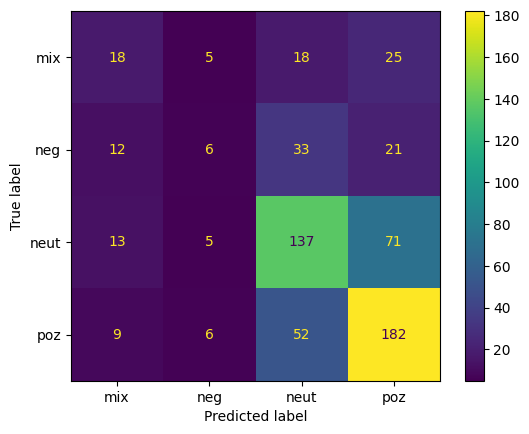

In [48]:
%matplotlib inline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix( labels_test, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,

                              display_labels=le.classes_)

disp.plot()

## Analysing the errors

In [55]:
# Create a DataFrame with text, predictions and true labels
data = {'Text':texts_test, 'Actual-Label': labels_test, 'Predicted-Label': predictions}
df_errors = pd.DataFrame(data)
print(len(df_errors))
df_errors[df_errors["Actual-Label"] != df_errors['Predicted-Label']]
# here you can see the sameples in the test set that are wrongly predicted

613


,Text,Actual-Label,Predicted-Label
2,"Ipak sam uživao u njegovu nastupu, kao i s dva...",3,2
10,Što bi bilo tužno ako nije uspješno komercijal...,0,2
12,Nije se činilo pretjerano dugim ili prekratkim.,3,2
14,"Ipak, ako vas privlači ovakav žanr filma, slob...",0,3
15,Tako je moj sinoćni pik pao na ‘Jupiter u uspo...,3,1
...,...,...,...
606,Čak i sa trajanjem od sat vremena i 40 minuta ...,0,2
608,"Detalje svoje veze, kao i odnosa Kenny i sa Ac...",2,3
610,"Kad sam vidio prvih nekoliko minuta, bio sam p...",0,3
611,A zaplet Kaijujevog ponovnog pojavljivanja vje...,1,0


# Add stop words for Croatian

In [22]:
import requests
raw_url = "https://raw.githubusercontent.com/stopwords-iso/stopwords-hr/master/stopwords-hr.txt"
response = requests.get(raw_url)

if response.status_code == 200:
  # Read the text content
  text_data = response.text

  # Split the text into lines by default
  data_list = text_data.splitlines()
data_list

['a',
 'ako',
 'ali',
 'bi',
 'bih',
 'bila',
 'bili',
 'bilo',
 'bio',
 'bismo',
 'biste',
 'biti',
 'bumo',
 'da',
 'do',
 'duž',
 'ga',
 'hoće',
 'hoćemo',
 'hoćete',
 'hoćeš',
 'hoću',
 'i',
 'iako',
 'ih',
 'ili',
 'iz',
 'ja',
 'je',
 'jedna',
 'jedne',
 'jedno',
 'jer',
 'jesam',
 'jesi',
 'jesmo',
 'jest',
 'jeste',
 'jesu',
 'jim',
 'joj',
 'još',
 'ju',
 'kada',
 'kako',
 'kao',
 'koja',
 'koje',
 'koji',
 'kojima',
 'koju',
 'kroz',
 'li',
 'me',
 'mene',
 'meni',
 'mi',
 'mimo',
 'moj',
 'moja',
 'moje',
 'mu',
 'na',
 'nad',
 'nakon',
 'nam',
 'nama',
 'nas',
 'naš',
 'naša',
 'naše',
 'našeg',
 'ne',
 'nego',
 'neka',
 'neki',
 'nekog',
 'neku',
 'nema',
 'netko',
 'neće',
 'nećemo',
 'nećete',
 'nećeš',
 'neću',
 'nešto',
 'ni',
 'nije',
 'nikoga',
 'nikoje',
 'nikoju',
 'nisam',
 'nisi',
 'nismo',
 'niste',
 'nisu',
 'njega',
 'njegov',
 'njegova',
 'njegovo',
 'njemu',
 'njezin',
 'njezina',
 'njezino',
 'njih',
 'njihov',
 'njihova',
 'njihovo',
 'njim',
 'njima',
 'n

# Lemmatise the words for Croatian

In [7]:
!pip install spacy

In [10]:
!python -m spacy download hr_core_news_md

✔ Download and installation successful
You can now load the package via spacy.load('hr_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [11]:
import spacy
from spacy.lang.hr.examples import sentences

nlp = spacy.load("hr_core_news_md",)
doc = nlp(sentences[0])
print(doc.text)
for token in doc:
    print(token.text, token.pos_, token.dep_)

Ovo je rečenica.
Ovo DET nsubj
je AUX cop
rečenica NOUN ROOT
. PUNCT punct


In [14]:
lemmas = " ".join([token.lemma_ for token in doc])
lemmas

'ovaj biti rečenica .'

# get confusion matrix

Error analysis